In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import os
import warnings
from configs.data import MACHINE_LEARNING_DATASET_PATH
from machine_learning.utils import split_data, scale_dataset
from machine_learning.neural_networks.utils import get_tensorflow_version, plot_history
from machine_learning.neural_networks.deep_fnn import train_deep_fnn_model
from configs.enums import Column, RiskClassifications
import numpy as np
import matplotlib.pyplot as plt
from configs.data import MERGED_DATASET_PATH, OUT_PATH, MODELS_PATH
import shap
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(0)

## Loading the dataset

In [2]:
df = pd.read_excel(MACHINE_LEARNING_DATASET_PATH)
train_df, valid_df, test_df = split_data(df)
train, x_train, train_labels = scale_dataset(train_df, oversample=True)
valid, x_val, val_labels = scale_dataset(valid_df, oversample=False)
test, x_test, test_labels = scale_dataset(test_df, oversample=False)

print(f"Train: {x_train.shape}, Valid: {x_val.shape}, Test: {x_test.shape}")

Train: (9696, 9), Valid: (1495, 9), Test: (1496, 9)


In [3]:
def print_results(model) -> None:
    y_pred_train = model.predict(x_train).argmax(axis=1)
    print("\n###### Training ######")
    print(classification_report(train_labels, y_pred_train))
    
    y_pred_valid = model.predict(x_val).argmax(axis=1)
    print("\n###### Validation ######")
    print(classification_report(val_labels, y_pred_valid))
    
    y_pred = model.predict(x_test).argmax(axis=1)
    print("\n###### Test ######")
    print(classification_report(test_labels, y_pred))

## Load model from file

In [4]:
model_file = "tf-2.15.0_Deep_Adam_8_256_0.2_0.001_1000_20_128_0.1691402643918991.fnn.keras"
model = tf.keras.models.load_model(os.path.join(MODELS_PATH, model_file))

print_results(model)

303/303 [==============================] - 1s 2ms/step

###### Training ######
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3232
           1       0.76      0.94      0.84      3232
           2       0.95      0.74      0.83      3232

    accuracy                           0.88      9696
   macro avg       0.90      0.88      0.88      9696
weighted avg       0.90      0.88      0.88      9696
47/47 [==============================] - 0s 1ms/step

###### Validation ######
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       299
           1       0.96      0.94      0.95      1078
           2       0.64      0.74      0.69       118

    accuracy                           0.93      1495
   macro avg       0.84      0.88      0.86      1495
weighted avg       0.93      0.93      0.93      1495

47/47 [==============================] - 0s 1ms/step

###### Test ######
        

## Automated tuning

In [ ]:
def tune_deep_fnn_model(df, layers, units, dropout_rates, learning_rates, epochs=200, patience=[10, 20], batch_sizes=[128]):
    import time
    from datetime import timedelta
    
    least_val_lost_file_name = f"tuning_least_val_loss.fnn.keras"
    
    to_hh_mm_ss = lambda seconds: str(timedelta(seconds=seconds)).rsplit(".")[0]
    
    least_val_loss = float('inf')
    least_val_loss_params = []
    least_val_loss_accuracy = float('inf')
    least_val_loss_model = None  
    least_val_loss_history = None
    eta = None
    
    time_past = 0
    
    i = 1 
    max = len(layers) * len(units) * len(dropout_rates) * len(learning_rates) * len(patience) * len(batch_sizes)
    
    print("[prev: N/A] [eta: TBD]")
    
    for l in layers:
        for u in units:
            for dr in dropout_rates:
                for lr in learning_rates: 
                    for pt in patience:
                        for bt in batch_sizes:
                            start_time = time.time()
    
                            print(f"[{i}/{max}] Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}")
                            
                            # TODO: add batch_size param to tune
                            model, history, num_classes = train_deep_fnn_model(
                                df, 
                                epochs=epochs, 
                                patience=pt, 
                                layers=l, 
                                units=u,
                                dropout_rate=dr,
                                learning_rate=lr,
                                batch_size=bt,
                                verbose=0,
                                disable_save=True,
                                disable_plot_history=True,
                                disable_print_report=True)
                            
                            val_loss, val_acc = model.evaluate(x_test, test_labels)
                            print(f"Loss: {val_loss}; Accuracy: {val_acc};")
                            if val_loss < least_val_loss:
                                model.save(os.path.join(MODELS_PATH, least_val_lost_file_name))
                                least_val_loss = val_loss
                                least_val_loss_params = [l, u, dr, lr, pt, bt]
                                least_val_loss_accuracy = val_acc
                                least_val_loss_model = model
                                least_val_loss_history = history
                                
                            duration = time.time() - start_time
                            time_past += duration
                            avg_duration = time_past / i
                            eta = time_past + avg_duration * (max - i)
                            
                            print(f"\n[eta: {to_hh_mm_ss(time_past)}/{to_hh_mm_ss(eta)}] [prev: {to_hh_mm_ss(duration)}] [avg: {to_hh_mm_ss(avg_duration)}]")
                                
                            i += 1
    
    l, u, dr, lr, pt, bt = least_val_loss_params
    print("\nLeast validation loss:")              
    print(f"\tParams:\t {{Layers: {l}; Units: {u}; Dropout rate: {dr}; Learning rate: {lr}; Patience: {pt}; Batch size: {bt}}}")
    print("\tLoss:\t", least_val_loss)
    print("\tAccuracy:\t", least_val_loss_accuracy)
    
    best_model_file_name = f"tf-{get_tensorflow_version()}_Deep_Adam_{l}_{u}_{dr}_{lr}_{epochs}_{pt}_{bt}_{least_val_loss}.fnn.keras"
    os.rename(
        os.path.join(MODELS_PATH, least_val_lost_file_name), 
        os.path.join(MODELS_PATH, best_model_file_name))
    print(f"\nModel has been saved as '{best_model_file_name}'")
    
    plot_history(least_val_loss_history, num_classes)
    
    print_results(model)
    
    return least_val_loss_model, least_val_loss_history, num_classes


In [ ]:
model, history, num_classes = tune_deep_fnn_model(
        df=df,
        epochs=1000,
        # Layers: 1, 2, 3, 4, 5, 6, 7
        layers=[8],
        # Units: 8, 16, 32, 64, 96, 128, 160, 192
        units=[256],
        # Dropout rates: 0.2, 0.3, 0.4, 0.5
        dropout_rates=[0.2], 
        # Learning rates: # 0.0001, 0.0005, 0.00075, 0.001, 0.00125, 0.0015, 0.00175, 0.002
        learning_rates=[0.001],   
        # Patience: 10, 20
        patience=[20],
        # Batch sizes: 10, 50, 100, 128, 150, 200, 250
        batch_sizes=[128]  
    )

# Least validation loss:
# 	Params:  [8, 256, 0.2, 0.0015, 20]
# 	Loss:  0.1532142609357834

# Least validation loss:
# 	Params:	 {Layers: 9; Units: 1024; Dropout rate: 0.2; Learning rate: 0.001; Patience: 20; Batch size: 128}
# 	Loss:	 0.13461776077747345

# [9/48] Layers: 6; Units: 512; Dropout rate: 0.2; Learning rate: 0.001; Patience: 10; Batch size: 128
# Loss: 0.15980109572410583; Accuracy: 0.9331550598144531;

## Manual Tuning

In [ ]:
model, _, num_classes = train_deep_fnn_model(
                        df, 
                        epochs=2000, 
                        patience=20, 
                        layers=8, 
                        units=256,
                        dropout_rate=0.2,
                        learning_rate=0.001,
                        verbose=2)
# epsilon=1 =>  0.41 loss, 0.80 acc | Interesting
# epsilon=1e-1 => 0.38 loss, 0.82 acc
# epsilon=1e-2 =>
# epsilon=1e-3 => 
# epsilon=1e-4 =>  0.197 loss, 0.907 acc
# epsilon=1e-5 =>  0.163 loss, 0.929 acc <= Curve looks better than DEFAULT
# epsilon=1e-6 =>  0.186 loss, 0.915 acc

# weight_decay=0.01 => Worth testing

# amsgrad=True => 0.189 loss, 0.915 acc 

# beta_1=0.95 => 0.170 loss, 0.922 acc
# beta_1=0.85 => 0.183 loss, 0.914 acc

# (DEFAULT; epsilon=1e-7, beta_1=0.9, amsgrad=False) =>  0.174 loss, 0.932 acc

print_results(model)

## Plot confusion matrix by risk classification

In [5]:
def split_confusion(data, classification):
    true_positives = data[
        (data["country_risk"] == classification) & 
        (data["predicted_country_risk"] == classification) 
    ]
    
    true_negatives = data[
        (data["country_risk"] != classification) & 
        (data["predicted_country_risk"] != classification) 
    ]
    
    false_positives = data[
        (data["country_risk"] != classification) & 
        (data["predicted_country_risk"] == classification) 
    ]
    
    false_negatives = data[
        (data["country_risk"] == classification) & 
        (data["predicted_country_risk"] != classification) 
    ]
    
    return {"true_positives": true_positives, "true_negatives": true_negatives, "false_positives": false_positives, "false_negatives": false_negatives}

In [6]:
# model_file = "tf-2.14.0_Adam_8_256_0.2_0.0015_200_20_128_0.1532142609357834.fnn.keras"
# model = load_model(os.path.join(MODELS_PATH, model_file))
y_pred = model.predict(x_test).argmax(axis=1)

x_feature = Column.POL2
y_feature = Column.GDP_PC

result = test_df 
result["predicted_country_risk"] = y_pred

low, medium, high = [split_confusion(result, c) for c in [0,1,2]]
plot_data = high

47/47 [==============================] - 0s 2ms/step


In [7]:
def subplot_scatter(ax, x, y, title: str, color) -> None:
    ax.scatter(x, y, color=color)
    ax.grid(True)
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.set_xlabel(x_feature.get_description())
    ax.set_ylabel(y_feature.get_description())
    ax.title.set_text(title)
    
def subplot_scatter2(ax, data, risk_col: Column | str, title: str) -> None:
    low = data[data[risk_col] == 0]
    med = data[data[risk_col] == 1]
    hig = data[data[risk_col] == 2]
    
    l = ax.scatter(low[x_feature], low[y_feature], color="green")
    m = ax.scatter(med[x_feature], med[y_feature], color="yellow")
    h = ax.scatter(hig[x_feature], hig[y_feature], color="red")
    
    ax.legend([l, m, h], ("low", "medium", "high"), loc="best")
    ax.grid(True)
    ax.set_xlabel(x_feature.get_description())
    ax.set_ylabel(y_feature.get_description())
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))
    ax.title.set_text(title)

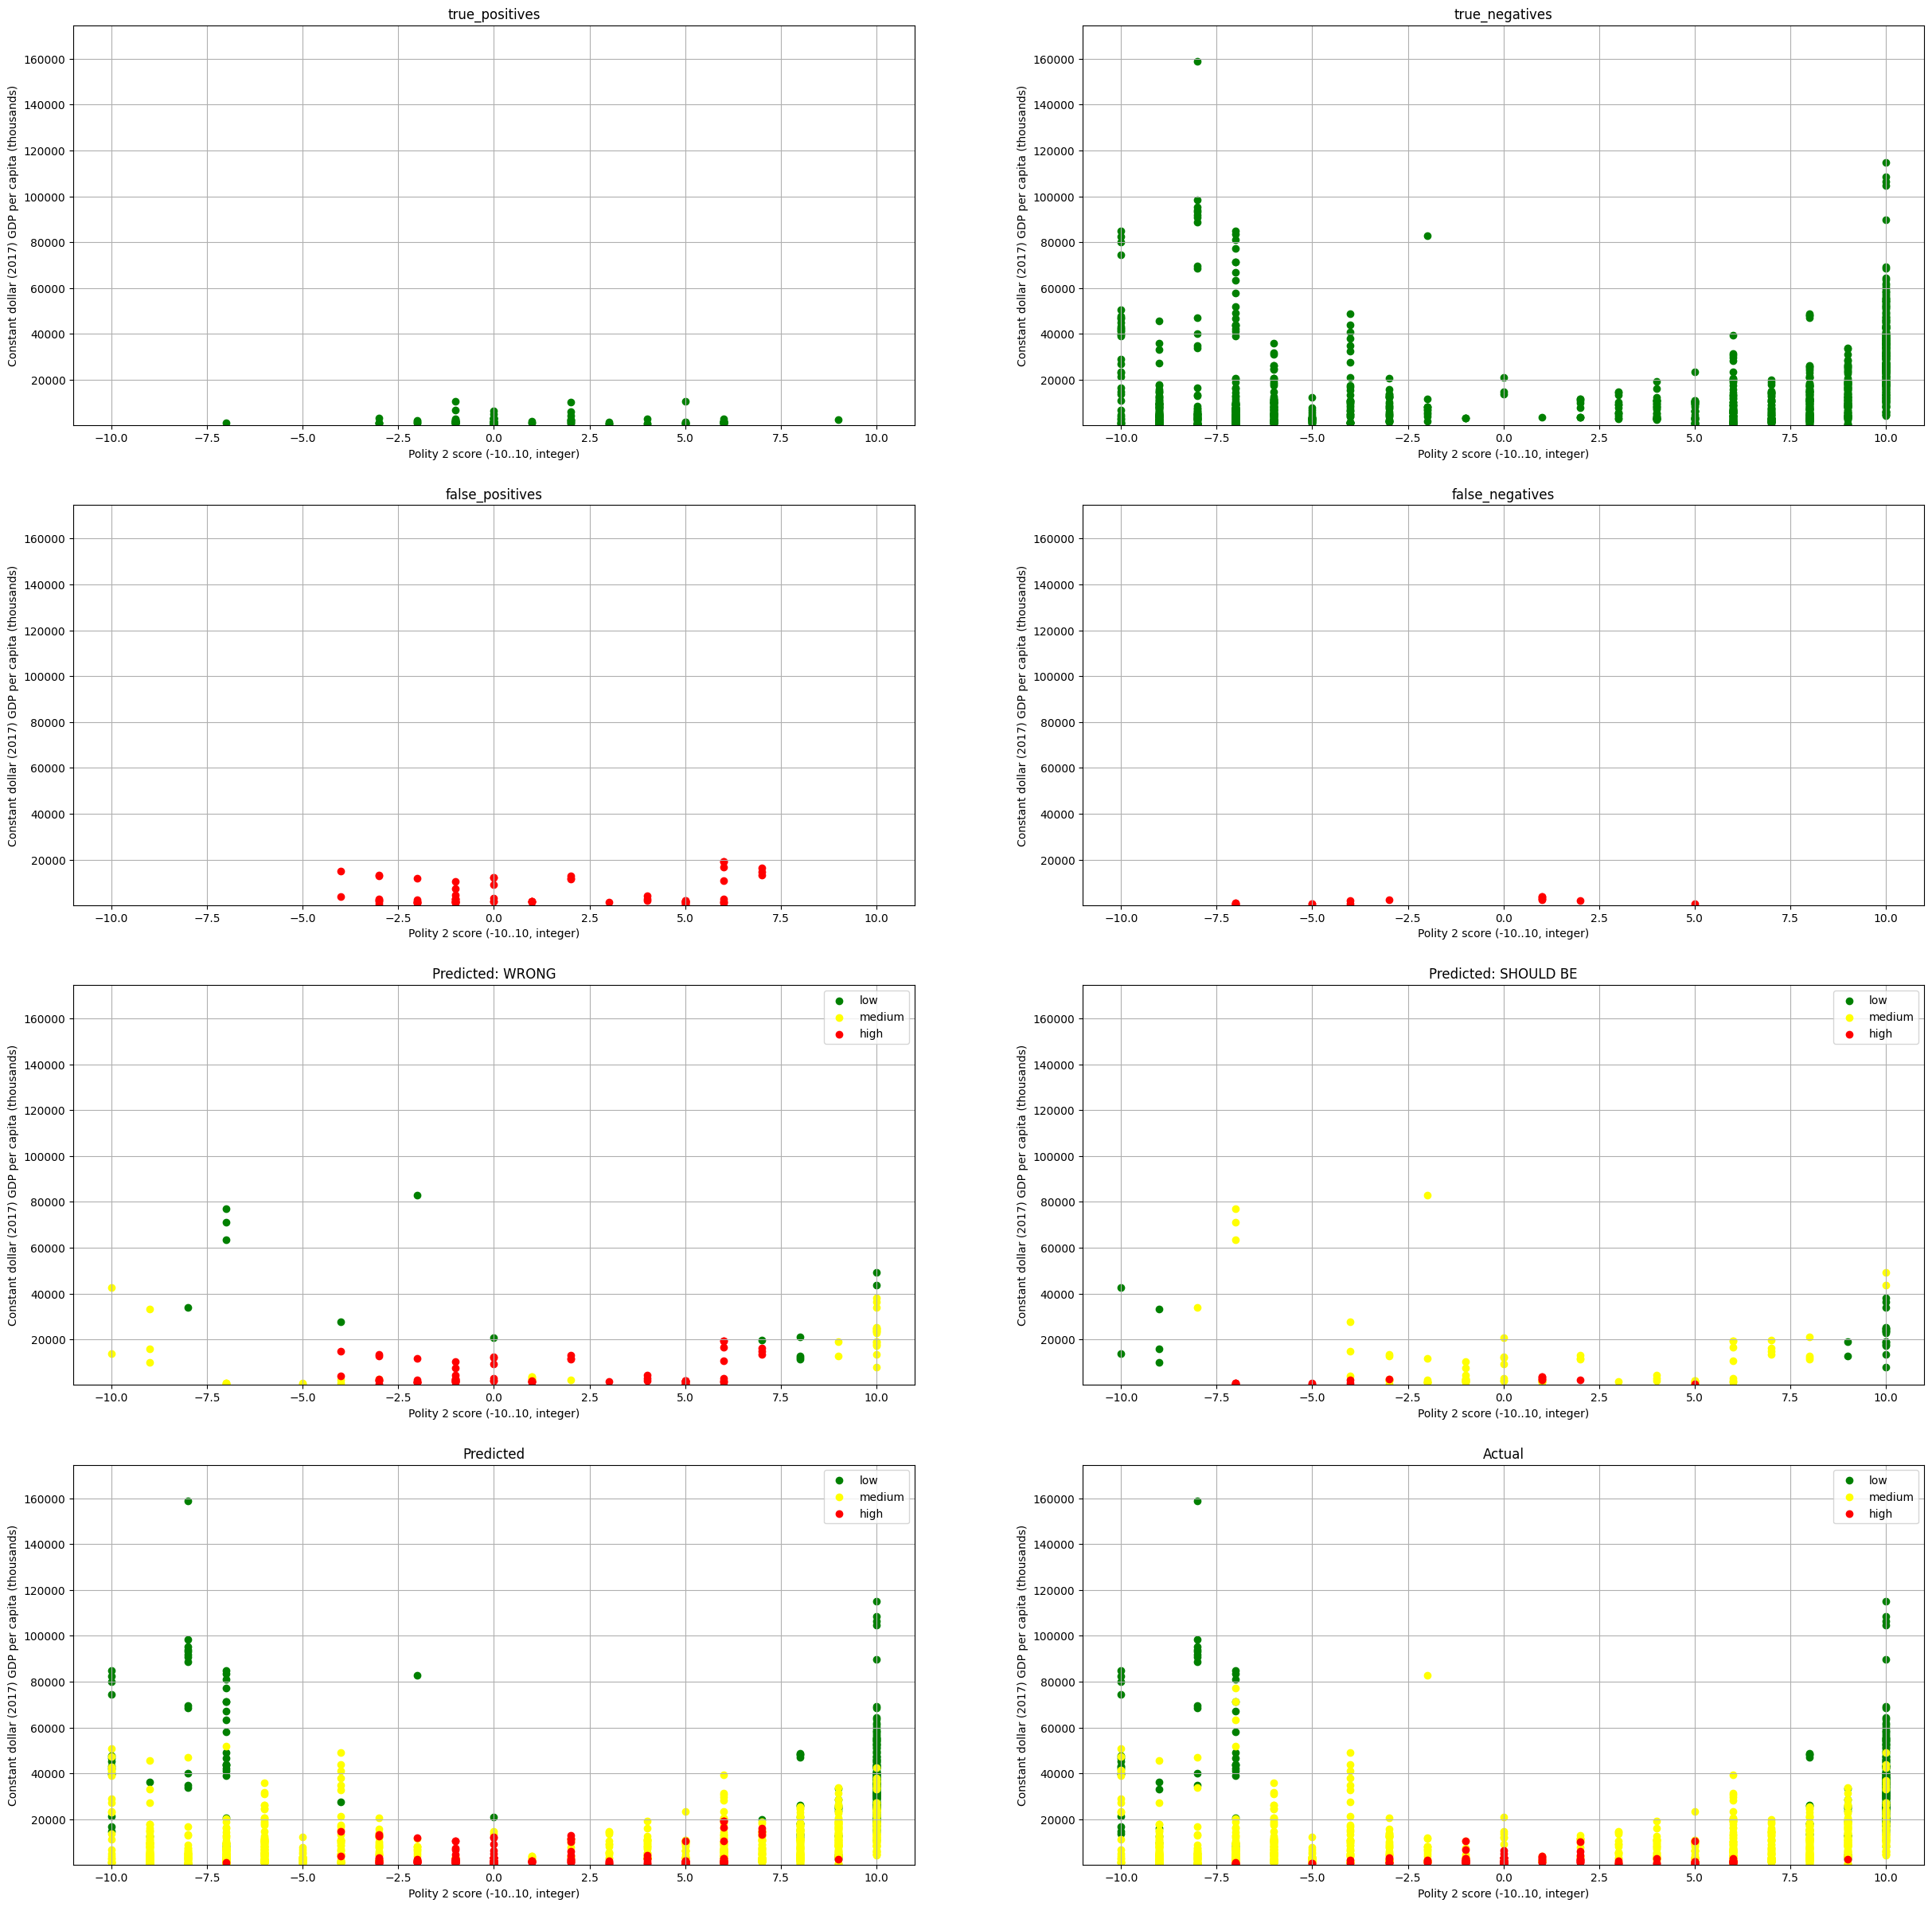

In [8]:
x_min = min([np.min(x[x_feature]) for x in plot_data.values()])
x_min -= abs(0.1 * x_min) 

y_min = min([np.min(y[y_feature]) for y in plot_data.values()])
y_min -= abs(0.1 * y_min)

x_max = max([np.max(x[x_feature]) for x in plot_data.values()]) * 1.1
y_max = max([np.max(y[y_feature]) for y in plot_data.values()]) * 1.1
    
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(30, 30))
subplot_scatter(ax1, plot_data["true_positives"][x_feature], plot_data["true_positives"][y_feature], "true_positives", color="green")
subplot_scatter(ax2, plot_data["true_negatives"][x_feature], plot_data["true_negatives"][y_feature], "true_negatives", color="green")
subplot_scatter(ax3, plot_data["false_positives"][x_feature], plot_data["false_positives"][y_feature], "false_positives", color="red")
subplot_scatter(ax4, plot_data["false_negatives"][x_feature], plot_data["false_negatives"][y_feature], "false_negatives", color="red")

wrongly_predicted = result[result["country_risk"] != result["predicted_country_risk"]]
subplot_scatter2(ax5, wrongly_predicted, "predicted_country_risk", title="Predicted: WRONG")
subplot_scatter2(ax6, wrongly_predicted, "country_risk", title="Predicted: SHOULD BE")

subplot_scatter2(ax7, result, "predicted_country_risk", title="Predicted")
subplot_scatter2(ax8, result, "country_risk", title="Actual")
plt.show()

## Print the distribution of the correct/wrong labeled test cases

In [12]:
distribution = result.groupby(["country_risk", "predicted_country_risk"]).size().reset_index().rename(columns={0: 'count'})

match_classifications = lambda dist: lambda c: [(dist[c] == 0), (dist[c] == 1), (dist[c] == 2)]
match_classifications_result = match_classifications(distribution)
options = ["low", "medium", "high"]
distribution["country_risk"] = np.select(match_classifications_result("country_risk"), options)
distribution["predicted_country_risk"] = np.select(match_classifications_result("predicted_country_risk"), options)

print(distribution)

  country_risk predicted_country_risk  count
0          low                    low    274
1          low                 medium     25
2       medium                    low     14
3       medium                 medium    997
4       medium                   high     67
5         high                 medium     17
6         high                   high    102


## Output an xlsx file containing the wrongly predicted rows

In [15]:
m_df = pd.read_excel(MERGED_DATASET_PATH)
wm_df = m_df.iloc[wrongly_predicted.index, ]
wm_df["predicted_country_risk"] = np.select(
    match_classifications(wrongly_predicted)("predicted_country_risk"),
    options)

cols = ["year", "country"] + list(wrongly_predicted.columns) + ["norm_risk"]

wm_df = wm_df[cols]
wm_df.to_excel(
            os.path.join(OUT_PATH, f"wrongly-predicted.xlsx"),
            index=False,
            sheet_name="Data")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### 2.4 Shap

In [ ]:
def shapify(data: pd.DataFrame):
    train, valid, test = split_data(data)

    train, x_train, train_labels = scale_dataset(train, oversample=True)
    valid, x_val, val_labels = scale_dataset(valid, oversample=False)
    test, x_test, test_labels = scale_dataset(test, oversample=False)
    
    explainer = shap.KernelExplainer(model.predict, x_train)
    shap_values = explainer.shap_values(x_test, nsamples=100) # nsamples { default = 2 * X.shape[1] + 2048 = 2066 }
    # explainer.save()
    
    return explainer, shap_values, x_test

In [ ]:
explainer, shap_values, shap_x_test = shapify(df[:1000])
shap.summary_plot(shap_values, shap_x_test, feature_names=df.columns[Column.COUNTRY_RISK], class_names=RiskClassifications.get_names())